In [1]:
import numpy as np
import copy
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix


import torch
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary
from torch.utils.data import DataLoader
import torch.optim as optim

## Function to Fix the seed for Reproduciblity

In [2]:
def fix_seed(np_seed, torch_seed):
    
    np_seed = np_seed
    torch_seed = torch_seed
    np.random.seed(np_seed)#60#20#30
    torch.manual_seed(torch_seed)
    if torch.cuda.is_available():
        # torch.cuda.empty_cache()
        torch.cuda.manual_seed_all(torch_seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
np_seed, torch_seed = 20, 20

# Generating Artificial Data

In [3]:
fix_seed(np_seed, torch_seed)

no_of_data = 100
no_train_data = int(no_of_data*0.80)
no_test_data = int(no_of_data*0.20)
x = 0.6
y = 0.6

mu1 = torch.tensor([x, y])
sigma1 = 0.1*torch.eye(2)
normal1 = torch.distributions.multivariate_normal.MultivariateNormal(loc=mu1, covariance_matrix=sigma1)

mu2 = torch.tensor([x, -y])
sigma2 = 0.1*torch.eye(2)
normal2 = torch.distributions.multivariate_normal.MultivariateNormal(loc=mu2, covariance_matrix=sigma2)

mu3 = torch.tensor([-x, -y])
sigma3 = 0.1*torch.eye(2)
normal3 = torch.distributions.multivariate_normal.MultivariateNormal(loc=mu3, covariance_matrix=sigma3)

mu4 = torch.tensor([-x, y])
sigma4 = 0.1*torch.eye(2)
normal4 = torch.distributions.multivariate_normal.MultivariateNormal(loc=mu4, covariance_matrix=sigma3)

data1 = normal1.sample((no_of_data,))
label1 = torch.from_numpy(np.array([0]*no_of_data))
data2 = normal2.sample((no_of_data,))
label2 = torch.from_numpy(np.array([1]*no_of_data))
data3 = normal3.sample((no_of_data,))
label3 = torch.from_numpy(np.array([2]*no_of_data))
data4 = normal4.sample((no_of_data,))
label4 = torch.from_numpy(np.array([3]*no_of_data))


training_data = torch.concat((data1[:no_train_data],
                              data2[:no_train_data],
                              data3[:no_train_data],
                              data4[:no_train_data]
                              ))
training_labels = torch.concat((label1[:no_train_data],
                                label2[:no_train_data],
                                label3[:no_train_data],
                                label4[:no_train_data]
                                ))
train_ds = list(zip(training_data, training_labels))

test_data = torch.concat((data1[no_train_data:],
                          data2[no_train_data:],
                          data3[no_train_data:],
                          data4[no_train_data:]
                          ))
test_labels = torch.concat((label1[no_train_data:],
                            label2[no_train_data:],
                            label3[no_train_data:],
                            label4[no_train_data:]
                            ))
valid_ds = list(zip(test_data, test_labels))

# Plotting the Generated Data:

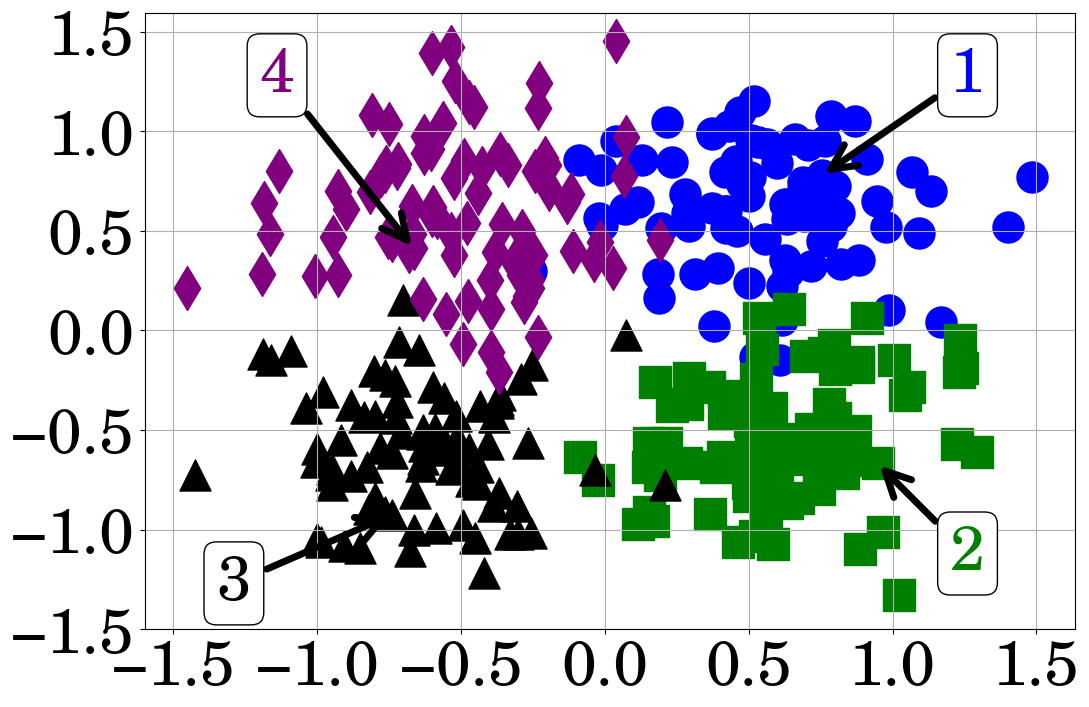

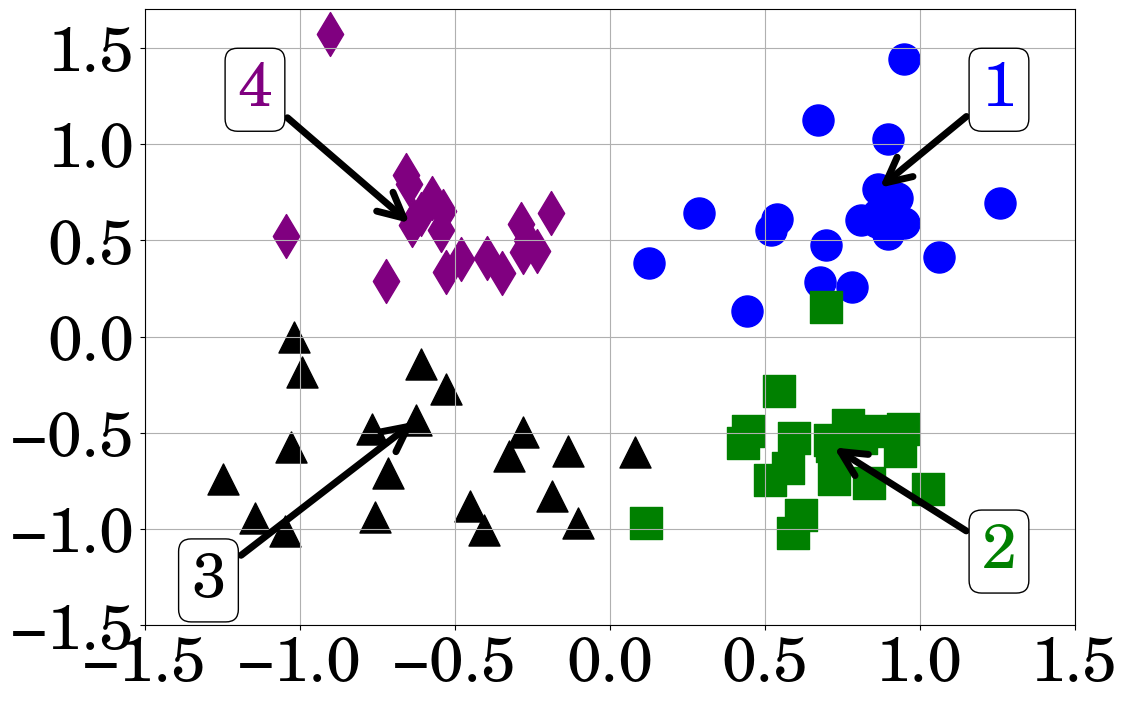

In [4]:
markers = ['o', 's', '^', 'd', 'p', 'x', 'X']
colors = ['blue', 'green', 'black', 'purple', 'red', 'brown', 'violet', 'darkorange', 'darkgoldenrod','yellow', 'magenta', 'gold', 'gray', 'pink', 'orange', 'cyan', 'deeppink']
s = 500
ann_color = 'black'
ann_fontsize = 45
ann_fontweight = 'normal'#'bold'
ann_bbox=dict(boxstyle='round,pad=0.2', facecolor='white', edgecolor='black')
fontname='C059'#'serif'
xyticks_fontweight='normal'#'bold'#
xylabel_fontweight='normal'#'bold'#'normal'#
xyticks_fontsize = 45
title_fontsize = 30
xticks = np.linspace(-1.5, 1.5, 7)
yticks = np.linspace(-1.5, 1.5, 7)

# Set default figure size
plt.rcParams['figure.figsize'] = (12, 8)
# Set the font to C059
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['C059']

for i in range(4):#plot each class with differnt shapes
    plt.scatter(training_data[i*no_train_data:(i+1)*no_train_data, 0],
                training_data[i*no_train_data:(i+1)*no_train_data, 1],
                marker = markers[i],
                color = colors[i],
                s = s
                )
plt.annotate('1',
            xy=training_data[0],
            xytext=mu1+np.array([0.60, 0.60]),
            color = colors[0],
            fontsize = ann_fontsize,
            fontweight = ann_fontweight,
            bbox=ann_bbox,
            arrowprops=dict(facecolor='black', arrowstyle='->', linewidth=5) 
            )
plt.annotate('2',
            xy=training_data[80],
            xytext=mu2+np.array([0.60, -0.60]),
            color = colors[1],
            fontsize = ann_fontsize,
            fontweight = ann_fontweight,
            bbox=ann_bbox,
            arrowprops=dict(facecolor='black', arrowstyle='->', linewidth=5) 
            )
plt.annotate('3',
            xy=training_data[160],
            xytext=mu3+np.array([-0.75, -0.75]),
            color = colors[2],
            fontsize = ann_fontsize,
            fontweight = ann_fontweight,
            bbox=ann_bbox,
            arrowprops=dict(facecolor='black', arrowstyle='->', linewidth=5) 
            )
plt.annotate('4',
            xy=training_data[240],
            xytext=mu4+np.array([-0.60, 0.60]),
            color = colors[3],
            fontsize = ann_fontsize,
            fontweight = ann_fontweight,
            bbox=ann_bbox,
            arrowprops=dict(facecolor='black', arrowstyle='->', linewidth=5) 
            )
    # plt.annotate(str(i),
    #              eval(f'mu{i+1}'),
    #              color = ann_color,
    #              fontsize = ann_fontsize,
    #              fontweight = ann_fontweight,
    #              bbox=ann_bbox 
    #              )
# plt.title('Train Data', fontname=fontname, fontweight=xyticks_fontweight, fontsize=xyticks_fontsize+5)
plt.xticks(xticks, fontname=fontname, fontweight=xyticks_fontweight, fontsize=xyticks_fontsize)
plt.yticks(yticks, fontname=fontname, fontweight=xyticks_fontweight, fontsize=xyticks_fontsize)
plt.grid()
plt.savefig('./results/Toy_Example_Results/Train_Data.png', bbox_inches='tight')
plt.show()


for i in range(4):
    plt.scatter(test_data[i*no_test_data:(i+1)*no_test_data, 0],
                test_data[i*no_test_data:(i+1)*no_test_data, 1],
                marker = markers[i],
                color = colors[i],
                s = s
                )
plt.annotate('1',
            xy=test_data[0],
            xytext=mu1+np.array([0.60, 0.60]),
            color = colors[0],
            fontsize = ann_fontsize,
            fontweight = ann_fontweight,
            bbox=ann_bbox,
            arrowprops=dict(facecolor='black', arrowstyle='->', linewidth=5) 
            )
plt.annotate('2',
            xy=test_data[20],
            xytext=mu2+np.array([0.60, -0.60]),
            color = colors[1],
            fontsize = ann_fontsize,
            fontweight = ann_fontweight,
            bbox=ann_bbox,
            arrowprops=dict(facecolor='black', arrowstyle='->', linewidth=5) 
            )
plt.annotate('3',
            xy=test_data[40],
            xytext=mu3+np.array([-0.75, -0.75]),
            color = colors[2],
            fontsize = ann_fontsize,
            fontweight = ann_fontweight,
            bbox=ann_bbox,
            arrowprops=dict(facecolor='black', arrowstyle='->', linewidth=5) 
            )
plt.annotate('4',
            xy=test_data[65],
            xytext=mu4+np.array([-0.60, 0.60]),
            color = colors[3],
            fontsize = ann_fontsize,
            fontweight = ann_fontweight,
            bbox=ann_bbox,
            arrowprops=dict(facecolor='black', arrowstyle='->', linewidth=5) 
            )
# plt.title('Test Data', fontname=fontname, fontweight=xyticks_fontweight, fontsize=xyticks_fontsize+5)
plt.xticks(xticks, fontname=fontname, fontweight=xyticks_fontweight, fontsize=xyticks_fontsize)
plt.yticks(yticks, fontname=fontname, fontweight=xyticks_fontweight, fontsize=xyticks_fontsize)
plt.grid()
plt.savefig('./results/Toy_Example_Results/Test_Data.png', bbox_inches='tight')
plt.show()

# Defining the Model

In [5]:
fix_seed(np_seed, torch_seed)

## Classification Model
model = nn.Sequential(nn.Linear(2, 5),
                      nn.Sigmoid(),
                      nn.Linear(5, 4),
                      nn.Softmax(dim = 1)
                      )

optimizer = optim.Adam(params=model.parameters(), lr = 1e-3)
print(f'Model: {summary(model, (128, 2))}\n')


Model: ==========================================================================================
Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [128, 4]                  --
├─Linear: 1-1                            [128, 5]                  15
├─Sigmoid: 1-2                           [128, 5]                  --
├─Linear: 1-3                            [128, 4]                  24
├─Softmax: 1-4                           [128, 4]                  --
Total params: 39
Trainable params: 39
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.00
Estimated Total Size (MB): 0.01



# Model Training, Testing & other helper Functions:

In [6]:
def train(model, optimizer, train_loader, no_of_epochs=500):
        
    model.train()# switch to train mode
    epoch_train_losses = [None]*no_of_epochs
    epoch_train_accs = [None]*no_of_epochs
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    for epoch in range(no_of_epochs):
        epoch_train_loss = 0
        for batch, label in train_loader:
            batch, label = batch.to(device), label.to(device)
            optimizer.zero_grad()
            y_pred = model(batch)
            loss = F.cross_entropy(y_pred, label)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
            
        epoch_train_loss /= len(train_loader)
        _, epoch_train_acc, _, _ = accuracy(model, train_loader)
        epoch_train_losses[epoch] = epoch_train_loss
        epoch_train_accs[epoch] = epoch_train_acc
    model.eval()  
    
    return model, epoch_train_losses, epoch_train_accs



def set_parameter_requires_grad(model, requires_grad=False):
    for param in model.parameters():
        param.requires_grad = requires_grad
        
        

def accuracy(model, dataloader, aprox_ndigits = 2):
    
    actual_labels = []#*len(dataloader.dataset)
    predicted_labels = []#*len(dataloader.dataset)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        for batch, labels in dataloader:
            data = batch.to(device)
            predicted = model(data.type(torch.float))
            predicted = predicted.cpu().detach().numpy()
            predicted = np.argmax(predicted, axis=1)
            predicted_labels.extend(predicted)
            actual_labels.extend(labels)
            
    # num_classes = torch.unique(torch.tensor(actual_labels))
    confusion_matrix = metrics.confusion_matrix(actual_labels, predicted_labels)#Computing the confusion matrix
    acc = round((sum(confusion_matrix.diagonal())/np.sum(confusion_matrix))*100, aprox_ndigits)
    
    return confusion_matrix, acc, predicted_labels, predicted_labels



# function to convert to subscript 
def get_sub(x): 
	normal = "ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789+-=()"
	sub_s = "ₐ₈CDₑբGₕᵢⱼₖₗₘₙₒₚQᵣₛₜᵤᵥwₓᵧZₐ♭꜀ᑯₑբ₉ₕᵢⱼₖₗₘₙₒₚ૧ᵣₛₜᵤᵥwₓᵧ₂₀₁₂₃₄₅₆₇₈₉₊₋₌₍₎"
	res = x.maketrans(''.join(normal), ''.join(sub_s)) 
	return x.translate(res) 




def accuracy_(model,
              dataloader,
              unlearn_cls = 0,
              aprox_ndigits = 2,
              ):

    actual_labels = []#*len(dataloader.dataset)
    predicted_labels = []#*len(dataloader.dataset)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        for batch, labels in dataloader:
            data = batch.to(device)
            predicted = model(data.type(torch.float))
            predicted = predicted.cpu().detach().numpy()
            predicted = np.argmax(predicted, axis=1)
            predicted_labels.extend(predicted)
            actual_labels.extend(labels)
            
    # num_classes = torch.unique(torch.tensor(actual_labels))
    confusion_matrix = metrics.confusion_matrix(actual_labels, predicted_labels)#Computing the confusion matrix
    acc = round((sum(confusion_matrix.diagonal())/np.sum(confusion_matrix))*100, aprox_ndigits)
    classwise_accuracy = [round((confusion_matrix[i,i]/np.sum(confusion_matrix, axis=1)[i])*100, aprox_ndigits) for i in range(confusion_matrix.shape[0])]
    
    retain_acc = (sum(confusion_matrix.diagonal()) - confusion_matrix[unlearn_cls, unlearn_cls])/(np.sum(confusion_matrix) - np.sum(confusion_matrix[unlearn_cls]))
    retain_acc = round(retain_acc*100, aprox_ndigits)
    
    unlearn_acc = confusion_matrix[unlearn_cls, unlearn_cls]/np.sum(confusion_matrix[unlearn_cls])
    unlearn_acc = round(unlearn_acc*100, aprox_ndigits)
        
    return confusion_matrix, acc, classwise_accuracy, retain_acc, unlearn_acc


def plot_graph(X, Y,
               xlabel = 'epoch',
               ylabel = 'avg. loss',
               plot_title = 'Loss',
               curve_label = 'loss: train',
               legend_loc = 'upper right',
               markersize = 20,
               marker = '',
               linewidth = 2,
               linestyle = '-',
               xyticks_fontsize = 20,
               title_fontsize = 25
               ):
    plt.plot(X, Y,
            marker = marker, 
            markersize = markersize, 
            linewidth = linewidth, 
            linestyle = linestyle, 
            label = curve_label
            )
    plt.xticks(fontsize = xyticks_fontsize)
    plt.yticks(fontsize = xyticks_fontsize)
    plt.xlabel(xlabel, fontsize = title_fontsize)
    plt.ylabel(ylabel, fontsize = title_fontsize)
    plt.grid(linestyle = '--')
    plt.legend(loc = legend_loc)
    plt.title(plot_title, fontsize = title_fontsize)
    
    plt.show(block = False)

# Training the Model:

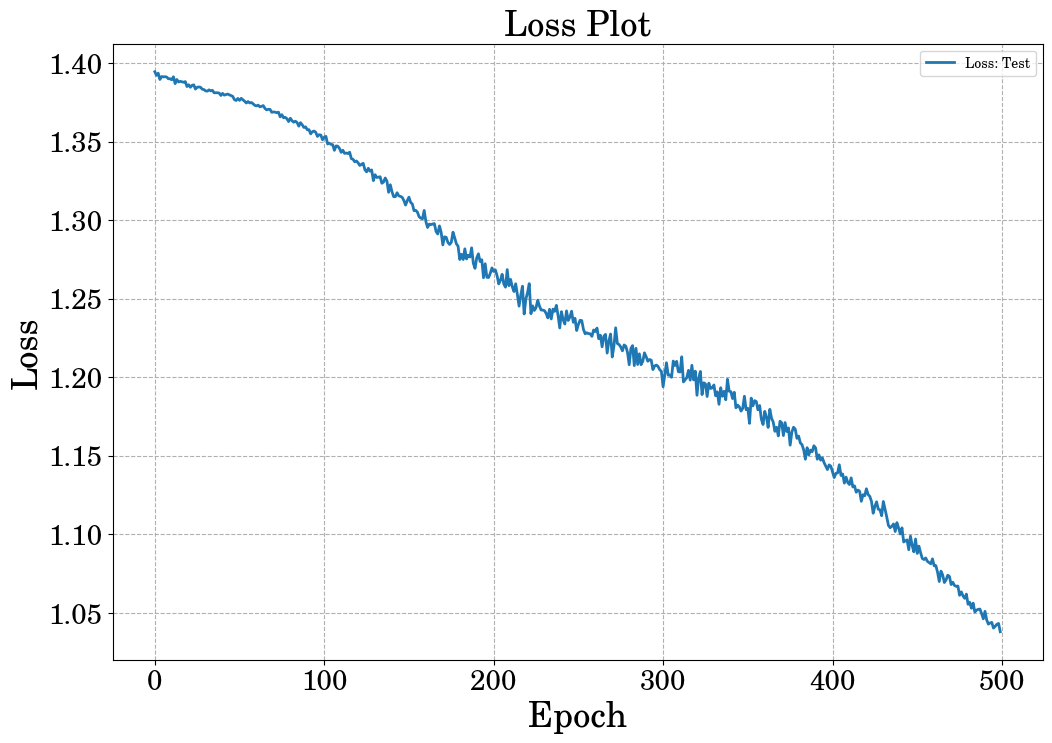

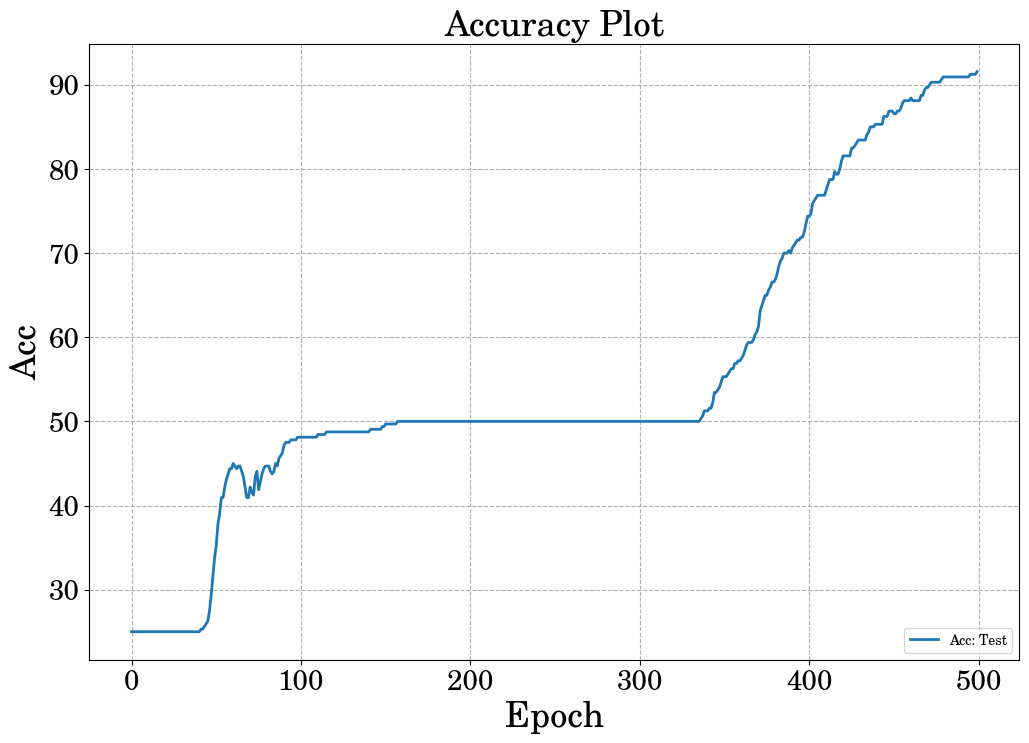

/tmp/ipykernel_18967/801231964.py:64: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels([f'{int((tick/max(tick_labels))*100)}%' for tick in tick_labels])


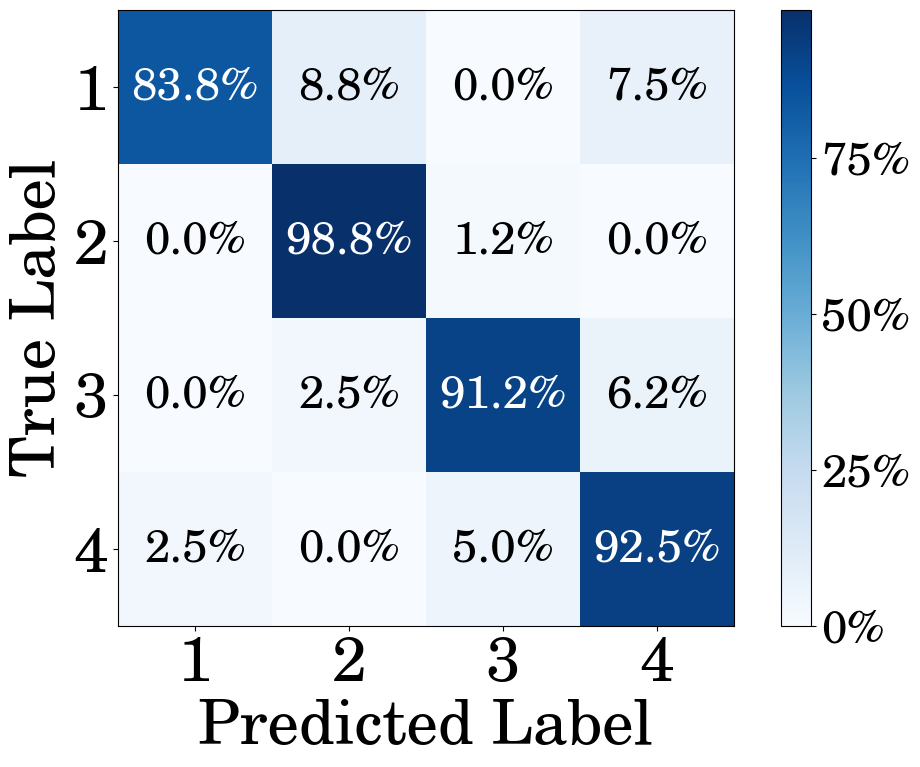

Accuracy on the Training Data after Training: 91.56


/tmp/ipykernel_18967/801231964.py:107: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels([f'{int((tick/max(tick_labels))*100)}%' for tick in tick_labels])


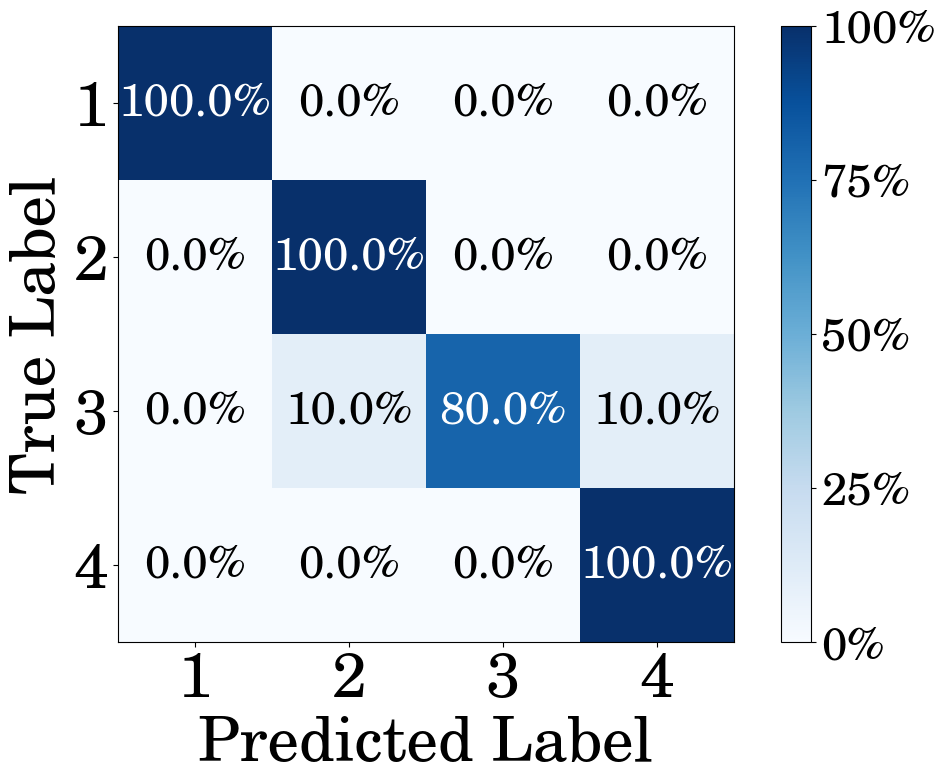

Accuracy on the Test Data after Training: 95.0


In [7]:
fix_seed(np_seed, torch_seed)

batch_size = 128
no_of_train_epochs = 500

train_loader = DataLoader(list(zip(training_data,training_labels)), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(list(zip(test_data, test_labels)), batch_size=batch_size, shuffle=False)

model, epoch_train_losses, epoch_train_accs = train(model=model, optimizer= optimizer, train_loader=train_loader, no_of_epochs=no_of_train_epochs) 


## Plotting Loss
plot_graph(X = np.arange(len(epoch_train_losses)),
           Y = epoch_train_losses,
           xlabel='Epoch',
           ylabel='Loss',
           curve_label='Loss: Test',
           plot_title='Loss Plot'
           )

## Plotting Accuracies
plot_graph(X = np.arange(len(epoch_train_accs)),
           Y = epoch_train_accs,
           xlabel='Epoch',
           ylabel='Acc',
           curve_label='Acc: Test',
           plot_title='Accuracy Plot',
           legend_loc='lower right'
           )

confusion_matrix, acc, _, _ = accuracy(model=model, dataloader=train_loader)

# Calculate percentages
cm_sum = confusion_matrix.sum(axis=1, keepdims=True)
cm_percentage = confusion_matrix / cm_sum.astype(float) * 100

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = list(range(1,5)))
fig, ax = plt.subplots(figsize = (12, 8))
cm_display.plot(ax=ax, cmap = 'Blues', colorbar=False)
plt.xticks(fontname=fontname, fontweight=xyticks_fontweight, fontsize=xyticks_fontsize)  # Set x-tick size and rotate labels
plt.yticks(fontname=fontname, fontweight=xyticks_fontweight, fontsize=xyticks_fontsize)
ax.set_xlabel('Predicted Label',fontname=fontname, fontweight=xyticks_fontweight, fontsize=xyticks_fontsize)
ax.set_ylabel('True Label', fontname=fontname, fontweight=xyticks_fontweight, fontsize=xyticks_fontsize)

# Remove the text annotations
for text in ax.texts:
    text.set_visible(False)

# Annotate each cell with the number and percentage
for i in range(confusion_matrix.shape[0]):
    for j in range(confusion_matrix.shape[1]):
        ax.text(j, i, f'{cm_percentage[i, j]:.1f}%',#\n({confusion_matrix[i, j]})',
                ha='center', va='center', color='white' if cm_percentage[i, j] >= 70 else 'black')
for text in ax.texts:
    text.set_fontsize(xyticks_fontsize-12)  # Set font size
    text.set_fontweight(xyticks_fontweight)  # Set font weight
    text.set_fontname(fontname)
cbar = ax.figure.colorbar(cm_display.im_, ax=ax)

# Format the colorbar ticks to show percentages
tick_labels = cbar.ax.get_yticks()
tick_labels = np.linspace(0, max(tick_labels), 5)
# print([f'{int((tick/max(tick_labels))*100)}%' for tick in tick_labels])
cbar.ax.set_yticklabels([f'{int((tick/max(tick_labels))*100)}%' for tick in tick_labels])
cbar.ax.tick_params(labelsize=xyticks_fontsize-12)
for label in cbar.ax.get_yticklabels():
    label.set_fontweight('normal')

# plt.title('Train Confusion Matrix', fontname=fontname, fontweight=xyticks_fontweight, fontsize=xyticks_fontsize+3)
plt.savefig('./results/Toy_Example_Results/Train_Confusion_Matrix.png', bbox_inches='tight')
plt.show()
print(f'Accuracy on the Training Data after Training: {acc}')


confusion_matrix, acc, _, _ = accuracy(model=model, dataloader=test_loader)

# Calculate percentages
cm_sum = confusion_matrix.sum(axis=1, keepdims=True)
cm_percentage = confusion_matrix / cm_sum.astype(float) * 100
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = list(range(1,5)))
fig, ax = plt.subplots(figsize = (12, 8))
colorbar = cm_display.plot(ax=ax, cmap = 'Blues', colorbar=False)
plt.xticks(fontname=fontname, fontweight=xyticks_fontweight, fontsize=xyticks_fontsize)  # Set x-tick size and rotate labels
plt.yticks(fontname=fontname, fontweight=xyticks_fontweight, fontsize=xyticks_fontsize)
ax.set_xlabel('Predicted Label',fontname=fontname, fontweight=xyticks_fontweight, fontsize=xyticks_fontsize)
ax.set_ylabel('True Label', fontname=fontname, fontweight=xyticks_fontweight, fontsize=xyticks_fontsize)


# Remove the text annotations
for text in ax.texts:
    text.set_visible(False)

# Annotate each cell with the number and percentage
for i in range(confusion_matrix.shape[0]):
    for j in range(confusion_matrix.shape[1]):
        ax.text(j, i, f'{cm_percentage[i, j]:.1f}%',#\n({confusion_matrix[i, j]})',
                ha='center', va='center', color='white' if cm_percentage[i, j] >= 70 else 'black')
for text in ax.texts:
    text.set_fontsize(xyticks_fontsize-12)  # Set font size
    text.set_fontweight(xyticks_fontweight)  # Set font weight
    text.set_fontname(fontname)
cbar = ax.figure.colorbar(cm_display.im_, ax=ax)

# Format the colorbar ticks to show percentages
tick_labels = cbar.ax.get_yticks()
tick_labels = np.linspace(0, max(tick_labels), 5)
cbar.ax.set_yticklabels([f'{int((tick/max(tick_labels))*100)}%' for tick in tick_labels])
cbar.ax.tick_params(labelsize=xyticks_fontsize-12)
for label in cbar.ax.get_yticklabels():
    label.set_fontweight('normal')

# plt.title('Test Confusion Matrix', fontname=fontname, fontweight=xyticks_fontweight, fontsize=xyticks_fontsize+3)
plt.savefig('./results/Toy_Example_Results/Test_Confusion_Matrix.png', bbox_inches='tight')
plt.show()

print(f'Accuracy on the Test Data after Training: {acc}')

# Unlearn Parameters

In [8]:
unlearn_cls = 0

# Unlearn Using Error-Maximization Method:

#### Step-1: Noise Generation

In [9]:
fix_seed(np_seed, torch_seed)
train_epochs = 50
num_steps = 8
num_noises = 256
fully_trained_model_em = copy.deepcopy(model)

# defining the noise structure
class Noise(nn.Module):
    def __init__(self, *dim):
        super().__init__()
        self.noise = torch.nn.Parameter(torch.randn(*dim), requires_grad = True)
        
    def forward(self):
        return self.noise
    

generated_noises = {}
for cls in range(4):
    noises = Noise(num_noises, 2)
    init_noise = copy.deepcopy(noises())
    opt = torch.optim.Adam(noises.parameters(), lr = 0.1)

    unlearn_labels = torch.from_numpy(np.array([cls]*num_noises)).to(device)
    for epoch in range(train_epochs):
        total_loss = []
        for batch in range(num_steps):
            inputs = noises().to(device)
            outputs = fully_trained_model_em(inputs)
            loss = -F.cross_entropy(outputs, unlearn_labels)+ 0.1*torch.mean(torch.sum(torch.square(inputs), [1]))
            opt.zero_grad()
            loss.backward()
            opt.step()
            total_loss.append(loss.cpu().detach().numpy())
        print("Loss: {}".format(np.mean(total_loss)))
    generated_noises[cls] = noises().detach().numpy()
    
# print(generated_noises)

Loss: -1.3796391487121582
Loss: -1.4945099353790283
Loss: -1.5106258392333984
Loss: -1.5167293548583984
Loss: -1.520864486694336
Loss: -1.5223737955093384
Loss: -1.523187279701233
Loss: -1.5236449241638184
Loss: -1.5238080024719238
Loss: -1.5238949060440063
Loss: -1.5239650011062622
Loss: -1.523977279663086
Loss: -1.5239888429641724
Loss: -1.5239918231964111
Loss: -1.523993968963623
Loss: -1.5239946842193604
Loss: -1.5239949226379395
Loss: -1.523995041847229
Loss: -1.5239951610565186
Loss: -1.5239951610565186
Loss: -1.5239951610565186
Loss: -1.5239951610565186
Loss: -1.5239951610565186
Loss: -1.5239951610565186
Loss: -1.5239951610565186
Loss: -1.5239951610565186
Loss: -1.5239951610565186
Loss: -1.5239951610565186
Loss: -1.5239951610565186
Loss: -1.5239951610565186
Loss: -1.5239951610565186
Loss: -1.5239951610565186
Loss: -1.5239951610565186
Loss: -1.5239951610565186
Loss: -1.5239951610565186
Loss: -1.5239951610565186
Loss: -1.5239951610565186
Loss: -1.5239951610565186
Loss: -1.52399516

#### Step-2: Plotting Generated Noises

/home/dell/anaconda3/envs/condapy310/lib/python3.10/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8320 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/dell/anaconda3/envs/condapy310/lib/python3.10/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 8320 missing from current font.
  font.set_text(s, 0, flags=flags)


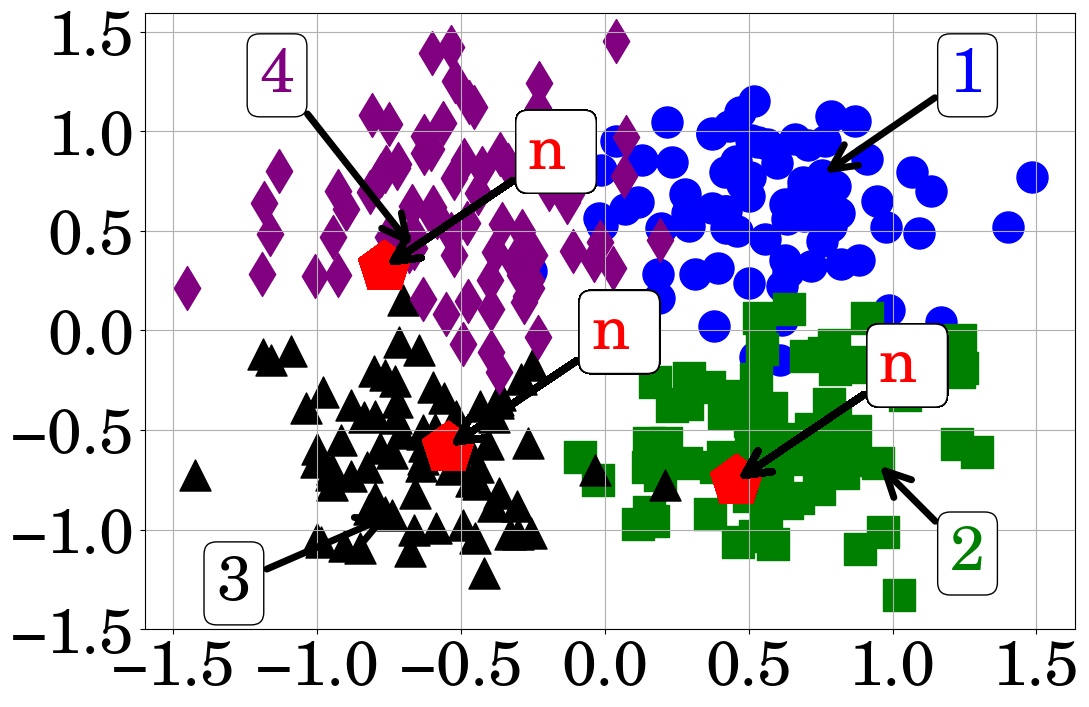

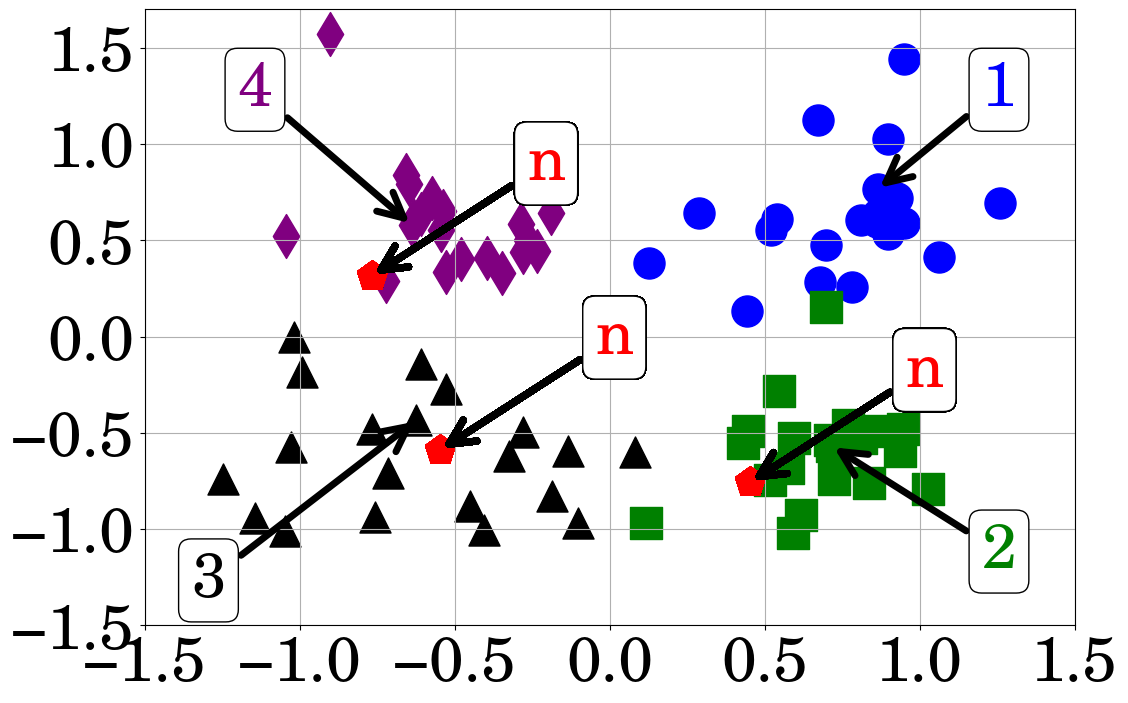

In [10]:
## Plotting Training Data with Noise:
for i in range(4):
    plt.scatter(training_data[i*no_train_data:(i+1)*no_train_data, 0],
                training_data[i*no_train_data:(i+1)*no_train_data, 1],
                marker = markers[i],
                color = colors[i],
                s = s
                )
    
plt.annotate('1',
            xy=training_data[0],
            xytext=mu1+np.array([0.60, 0.60]),
            color = colors[0],
            fontsize = ann_fontsize,
            fontweight = ann_fontweight,
            bbox=ann_bbox,
            arrowprops=dict(facecolor='black', arrowstyle='->', linewidth=5) 
            )
plt.annotate('2',
            xy=training_data[80],
            xytext=mu2+np.array([0.60, -0.60]),
            color = colors[1],
            fontsize = ann_fontsize,
            fontweight = ann_fontweight,
            bbox=ann_bbox,
            arrowprops=dict(facecolor='black', arrowstyle='->', linewidth=5) 
            )
plt.annotate('3',
            xy=training_data[160],
            xytext=mu3+np.array([-0.75, -0.75]),
            color = colors[2],
            fontsize = ann_fontsize,
            fontweight = ann_fontweight,
            bbox=ann_bbox,
            arrowprops=dict(facecolor='black', arrowstyle='->', linewidth=5) 
            )
plt.annotate('4',
            xy=training_data[240],
            xytext=mu4+np.array([-0.60, 0.60]),
            color = colors[3],
            fontsize = ann_fontsize,
            fontweight = ann_fontweight,
            bbox=ann_bbox,
            arrowprops=dict(facecolor='black', arrowstyle='->', linewidth=5) 
            )
    # plt.annotate(str(i),
    #              eval(f'mu{i+1}'),
    #              color = ann_color,
    #              fontsize = ann_fontsize,
    #              fontweight = ann_fontweight,
    #              bbox=ann_bbox 
    #              )
    
for cls, antisamples in generated_noises.items():
    if cls == unlearn_cls:
        plt.scatter(antisamples[:, 0],
                    antisamples[:, 1],
                    marker = markers[i+1],
                    color = colors[i+1],
                    s = 3*s
                    )
        for point in antisamples:
            plt.annotate(f'n{get_sub(str(unlearn_cls))}',
                         xy=point,
                         xytext=point+0.5,
                         color = colors[i+1],
                         fontsize = ann_fontsize,
                         fontweight = ann_fontweight,
                         bbox=ann_bbox,
                         arrowprops=dict(facecolor='black', arrowstyle='->', linewidth=5) 
                         )
# plt.title('Train Data with UNSIR Noise', fontname=fontname, fontweight=xyticks_fontweight, fontsize=title_fontsize)
plt.xticks(xticks, fontname=fontname, fontweight=xyticks_fontweight, fontsize=xyticks_fontsize)
plt.yticks(yticks, fontname=fontname, fontweight=xyticks_fontweight, fontsize=xyticks_fontsize)
plt.grid()
plt.savefig('./results/Toy_Example_Results/Train_Data_with_UNSIR_Noise.png', bbox_inches='tight')
plt.show(block = True)



## Plotting Test Data with Noise:
for i in range(4):
    plt.scatter(test_data[i*no_test_data:(i+1)*no_test_data, 0],
                test_data[i*no_test_data:(i+1)*no_test_data, 1],
                marker = markers[i],
                color = colors[i],
                s = s
                )
plt.annotate('1',
            xy=test_data[0],
            xytext=mu1+np.array([0.60, 0.60]),
            color = colors[0],
            fontsize = ann_fontsize,
            fontweight = ann_fontweight,
            bbox=ann_bbox,
            arrowprops=dict(facecolor='black', arrowstyle='->', linewidth=5) 
            )
plt.annotate('2',
            xy=test_data[20],
            xytext=mu2+np.array([0.60, -0.60]),
            color = colors[1],
            fontsize = ann_fontsize,
            fontweight = ann_fontweight,
            bbox=ann_bbox,
            arrowprops=dict(facecolor='black', arrowstyle='->', linewidth=5) 
            )
plt.annotate('3',
            xy=test_data[40],
            xytext=mu3+np.array([-0.75, -0.75]),
            color = colors[2],
            fontsize = ann_fontsize,
            fontweight = ann_fontweight,
            bbox=ann_bbox,
            arrowprops=dict(facecolor='black', arrowstyle='->', linewidth=5) 
            )
plt.annotate('4',
            xy=test_data[65],
            xytext=mu4+np.array([-0.60, 0.60]),
            color = colors[3],
            fontsize = ann_fontsize,
            fontweight = ann_fontweight,
            bbox=ann_bbox,
            arrowprops=dict(facecolor='black', arrowstyle='->', linewidth=5) 
            )
    # plt.annotate(str(i),
    #              eval(f'mu{i+1}')+torch.tensor([-0.1, 0.1]),
    #              color = ann_color,
    #              fontsize = ann_fontsize,
    #              fontweight = ann_fontweight,
    #              bbox=ann_bbox 
    #              )
for cls, antisamples in generated_noises.items():
    if cls == unlearn_cls:
        plt.scatter(antisamples[:, 0],
                    antisamples[:, 1],
                    marker = markers[i+1],
                    color = colors[i+1],
                    s = s
                    )
        for point in antisamples:
            plt.annotate(f'n',
                         xy=point,
                         xytext=point+0.5,
                         color = colors[i+1],
                         fontsize = ann_fontsize,
                         fontweight = ann_fontweight,
                         bbox=ann_bbox,
                         arrowprops=dict(facecolor='black', arrowstyle='->', linewidth=5) 
                         )
# plt.title('Test Data with UNSIR Noise', fontname=fontname, fontweight=xyticks_fontweight, fontsize=title_fontsize)
plt.xticks(xticks, fontname=fontname, fontweight=xyticks_fontweight, fontsize=xyticks_fontsize)
plt.yticks(yticks, fontname=fontname, fontweight=xyticks_fontweight, fontsize=xyticks_fontsize)
plt.grid()
plt.savefig('./results/Toy_Example_Results/Test_Data_with_UNSIR_Noise.png', bbox_inches='tight')
plt.show(block = True)

#### Unlearn Helper:

In [11]:
# Error Max Unleanring
unlearn_data = torch.concat(list( x for x, y in train_loader.dataset if y == unlearn_cls)).reshape(-1, 2)
unlearn_label = list( y for _, y in train_loader.dataset if y == unlearn_cls)
unlearn_loader = DataLoader(list(zip(unlearn_data, unlearn_label)), batch_size=batch_size, shuffle=True) 


impair_data = torch.concat(list(torch.from_numpy(generated_noises[unlearn_cls]))+list( x for x, y in train_loader.dataset if y != unlearn_cls)).reshape(-1, 2)
impair_label = [torch.tensor(unlearn_cls)]*len(generated_noises[unlearn_cls])+list(y for _, y in train_loader.dataset if y != unlearn_cls)
impair_loader = DataLoader(list(zip(impair_data, impair_label)), batch_size=batch_size, shuffle=True)

repair_data = torch.concat(list( x for x, y in train_loader.dataset if y != unlearn_cls)).reshape(-1, 2)
repair_label = list( y for _, y in train_loader.dataset if y != unlearn_cls)
repair_loader = DataLoader(list(zip(repair_data, repair_label)), batch_size=batch_size, shuffle=True)

#### Actual Unlearning(Repair + Impair):

Results after 1 + 1 epoch of Impair & Repair Step:

Accuracy after unlearning(epoch - 1) on Unlearn Data: 100.0
Accuracy after unlearning(epoch - 1) on Retain Data: 10.0


/tmp/ipykernel_18967/2200292707.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels([f'{int((tick/max(tick_labels))*100)}%' for tick in tick_labels])


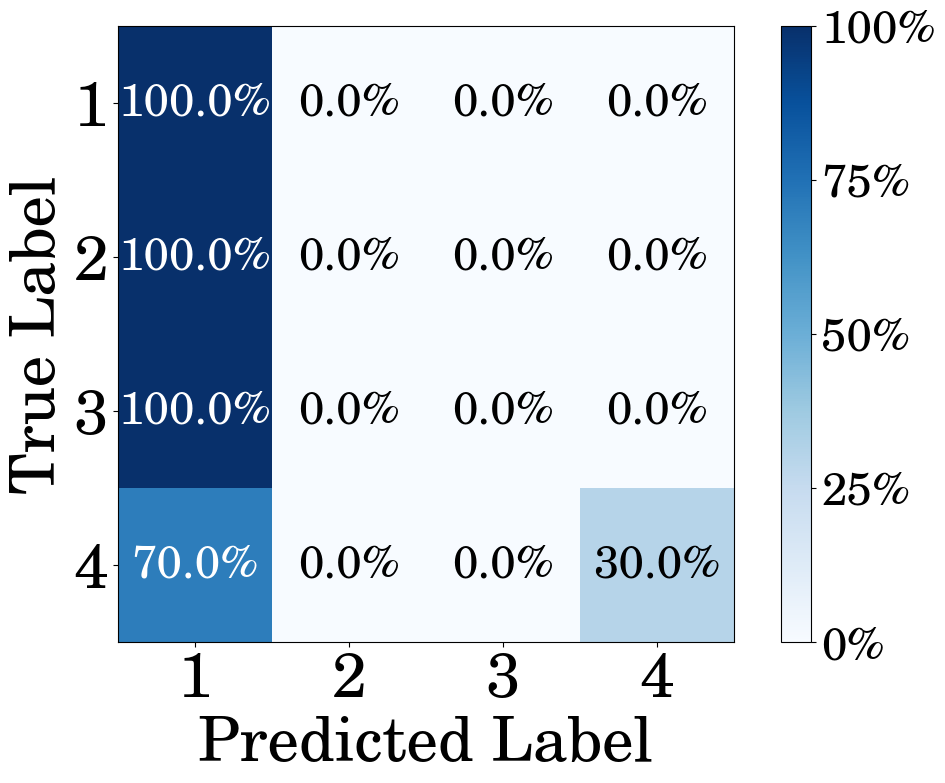

Accuracy after unlearning(epoch - 2) on Unlearn Data: 5.0
Accuracy after unlearning(epoch - 2) on Retain Data: 66.67


/tmp/ipykernel_18967/2200292707.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels([f'{int((tick/max(tick_labels))*100)}%' for tick in tick_labels])


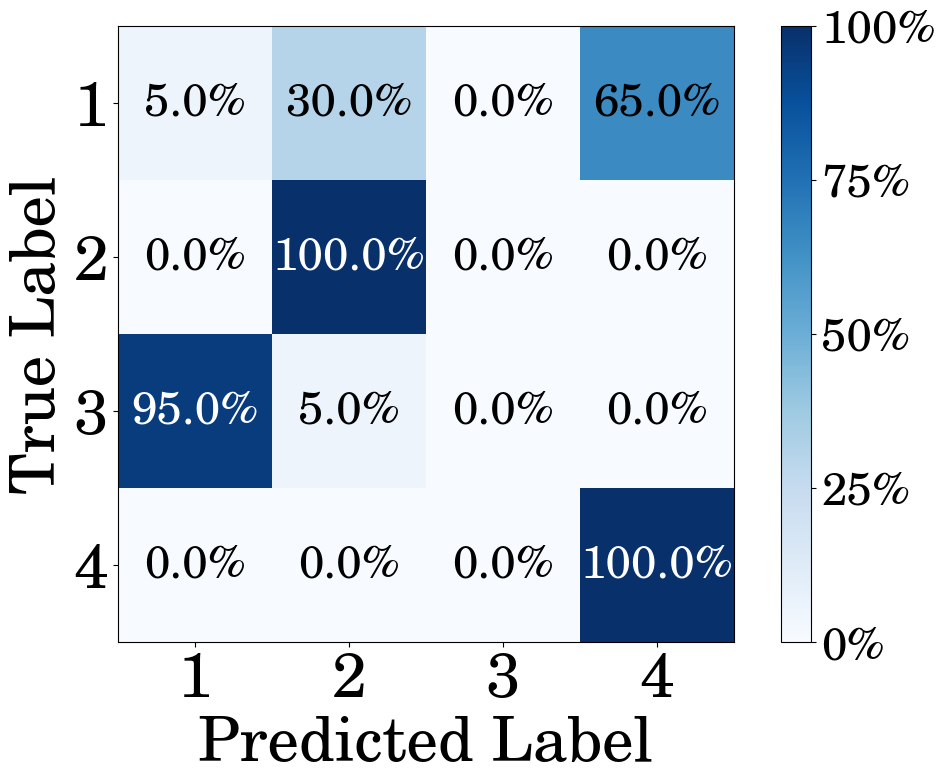

Accuracy after unlearning(epoch - 3) on Unlearn Data: 0.0
Accuracy after unlearning(epoch - 3) on Retain Data: 66.67


/tmp/ipykernel_18967/2200292707.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels([f'{int((tick/max(tick_labels))*100)}%' for tick in tick_labels])


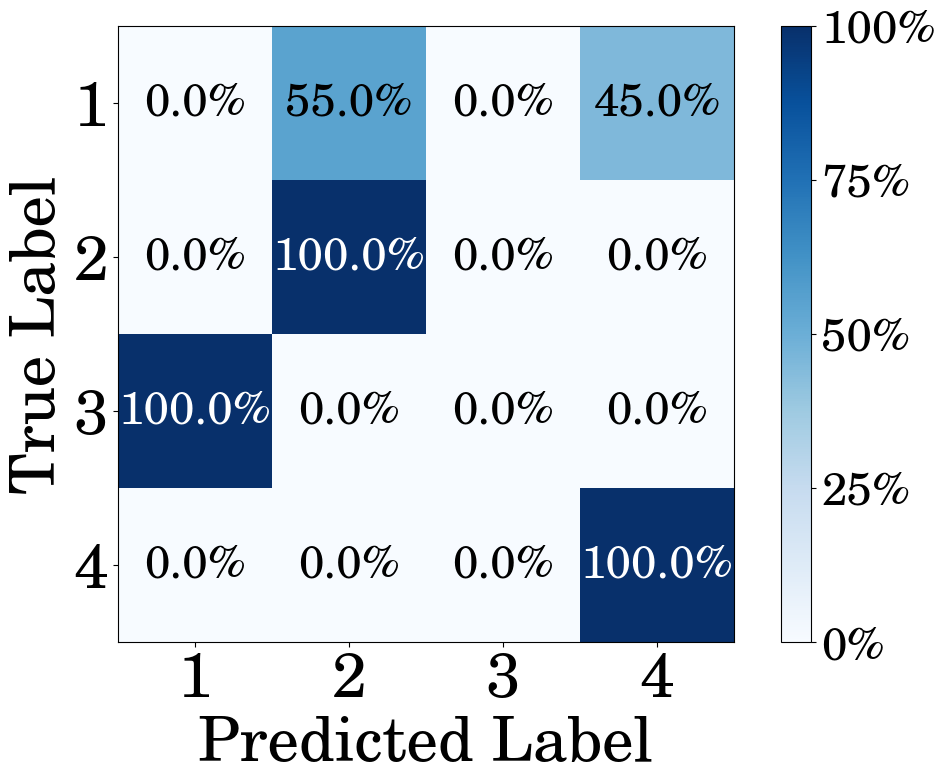

Accuracy after unlearning(epoch - 4) on Unlearn Data: 0.0
Accuracy after unlearning(epoch - 4) on Retain Data: 95.0


/tmp/ipykernel_18967/2200292707.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels([f'{int((tick/max(tick_labels))*100)}%' for tick in tick_labels])


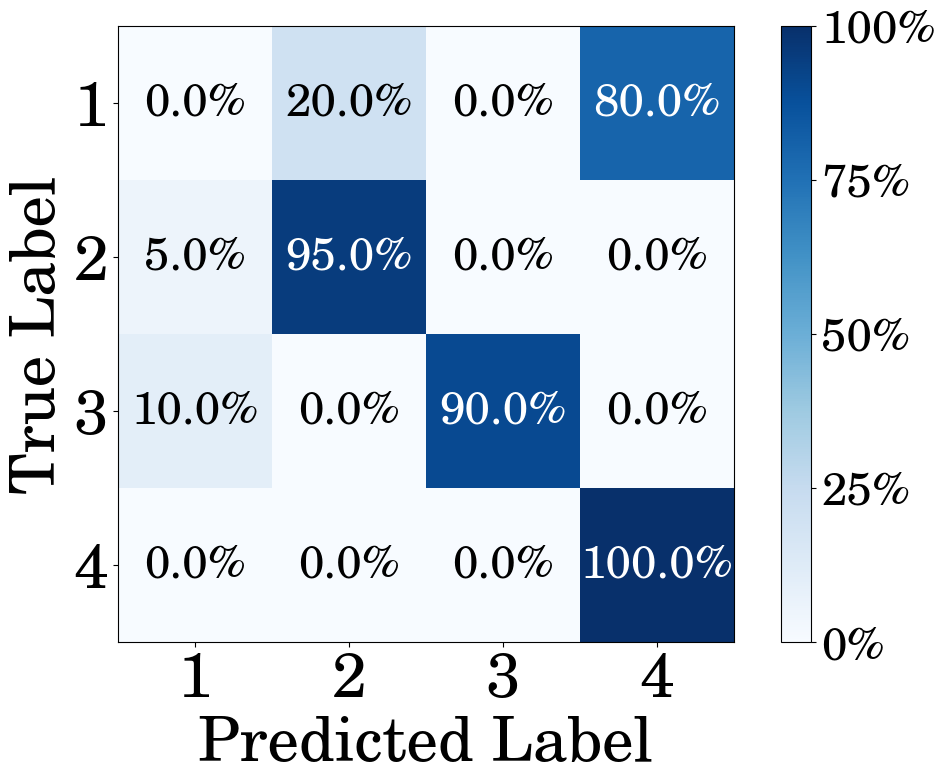

Accuracy after unlearning(epoch - 5) on Unlearn Data: 0.0
Accuracy after unlearning(epoch - 5) on Retain Data: 63.33


/tmp/ipykernel_18967/2200292707.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels([f'{int((tick/max(tick_labels))*100)}%' for tick in tick_labels])


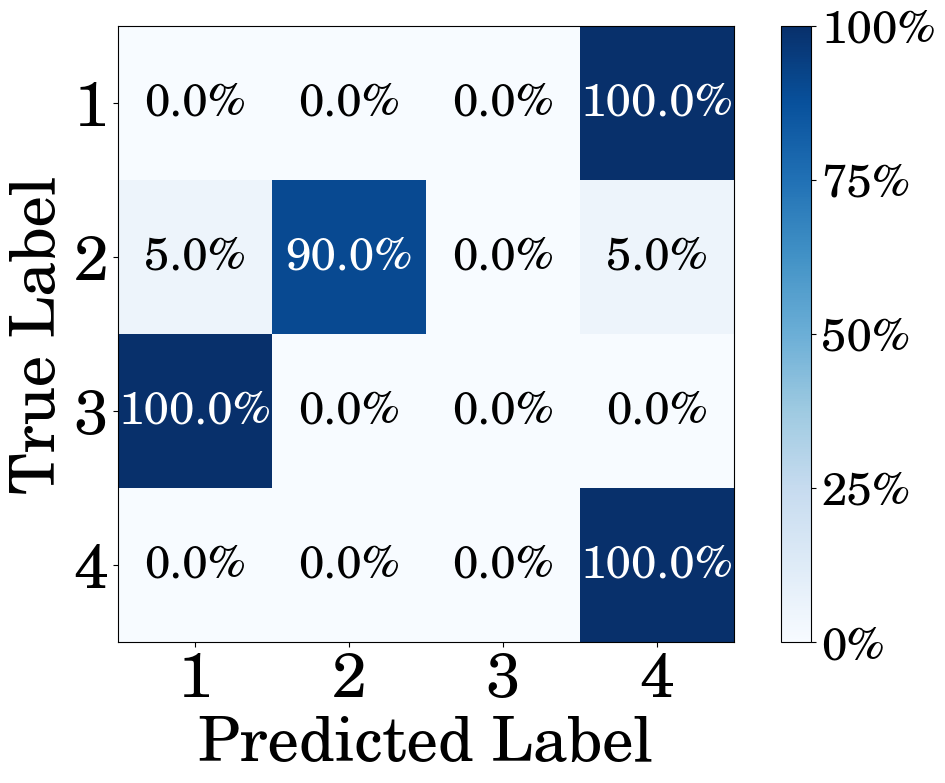

In [12]:
fix_seed(np_seed, torch_seed)

no_of_impair_repair_pairs = 5
print('Results after 1 + 1 epoch of Impair & Repair Step:\n')
err_max_unlearn_model = copy.deepcopy(fully_trained_model_em)
for epoch in range(no_of_impair_repair_pairs):
    optimizer = optim.Adam(params=err_max_unlearn_model.parameters(), lr = 300*1e-3)
    err_max_unlearn_model, _, _ = train(model=err_max_unlearn_model, optimizer=optimizer, train_loader=impair_loader, no_of_epochs=1)

    optimizer = optim.Adam(params=err_max_unlearn_model.parameters(), lr = 150*1e-3)
    err_max_unlearn_model, err_max_loss, err_max_acc = train(model=err_max_unlearn_model, optimizer=optimizer, train_loader=repair_loader, no_of_epochs=1)

    confusion_matrix, acc, classwise_accuracy, retain_acc, unlearn_acc = accuracy_(model=err_max_unlearn_model, dataloader=test_loader, unlearn_cls = unlearn_cls)
    print(f'Accuracy after unlearning(epoch - {epoch+1}) on Unlearn Data: {unlearn_acc}')
    print(f'Accuracy after unlearning(epoch - {epoch+1}) on Retain Data: {retain_acc}')

    cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = list(range(1,5)))
    # Calculate percentages
    cm_sum = confusion_matrix.sum(axis=1, keepdims=True)
    cm_percentage = confusion_matrix / cm_sum.astype(float) * 100
    
    fig, ax = plt.subplots(figsize=(12, 8))
    cm_display.plot(ax=ax, cmap='Blues', colorbar=False)
    plt.xticks(fontname=fontname, fontweight=xyticks_fontweight, fontsize=xyticks_fontsize)  # Set x-tick size and rotate labels
    plt.yticks(fontname=fontname, fontweight=xyticks_fontweight, fontsize=xyticks_fontsize)
    ax.set_xlabel('Predicted Label',fontname=fontname, fontweight=xyticks_fontweight, fontsize=xyticks_fontsize)
    ax.set_ylabel('True Label', fontname=fontname, fontweight=xyticks_fontweight, fontsize=xyticks_fontsize)
    
    # Remove the text annotations
    for text in ax.texts:
        text.set_visible(False)

    # Annotate each cell with the number and percentage
    for i in range(confusion_matrix.shape[0]):
        for j in range(confusion_matrix.shape[1]):
            ax.text(j, i, f'{cm_percentage[i, j]:.1f}%',#\n({confusion_matrix[i, j]})',
                    ha='center', va='center', color='white' if cm_percentage[i, j] >= 70 else 'black')

    for text in ax.texts:
        text.set_fontsize(xyticks_fontsize - 12)  # Set font size
        text.set_fontweight(xyticks_fontweight)  # Set font weight
        text.set_fontname(fontname)
    cbar = ax.figure.colorbar(cm_display.im_, ax=ax)
    
    # Format the colorbar ticks to show percentages
    tick_labels = cbar.ax.get_yticks()
    tick_labels = np.linspace(0, max(tick_labels)-min(tick_labels), 5)
    cbar.ax.set_yticklabels([f'{int((tick/max(tick_labels))*100)}%' for tick in tick_labels])
    cbar.ax.tick_params(labelsize=xyticks_fontsize-12)
    for label in cbar.ax.get_yticklabels():
        label.set_fontweight('normal')

    # plt.title(f'UNSIR Confusion Matrix(Epoch - {epoch+1})', fontname=fontname, fontweight=xyticks_fontweight, fontsize=title_fontsize)
    plt.savefig(f'./results/Toy_Example_Results/unsir_confusion_matrix_{epoch+1}ep.png', bbox_inches='tight')
    plt.show()

# Unlearning using Proposed Method(Unmunge algorithm):

In [13]:
def UNMUNGE_(unlearn_data,
             retain_data,
             retain_labels=0,
             local_variance = 10,
             size_multiplier = 1,
             p = 0.80,
             tail_randomized:int = None,
             no_generated_data = 50,
             eps = 1,
             convex_combination = True):
    
    print(f'Number of unlearn data = {len(unlearn_data)}')
    print(f'Number of retain data = {len(retain_data)}')
    flag1 = time.time()
    
    pairwise_distance = metrics.pairwise_distances(unlearn_data, retain_data)
    
    flag2 = time.time()
    
    unmunge_data = np.zeros((unlearn_data.shape[0]*size_multiplier, unlearn_data.shape[1]))
    farthest_point = [None]*unlearn_data.shape[0]*size_multiplier
    sorted_pairwise_indices = np.argsort(pairwise_distance)
    
    flag3 = time.time()
    for epoch in tqdm(range(size_multiplier)):
        if tail_randomized:
            tail_idx = np.random.choice(a = range(1, tail_randomized+1), size=unlearn_data.shape[0])
            farthest_neighbour_indices = sorted_pairwise_indices[range(sorted_pairwise_indices.shape[0]), -tail_idx]
        else:
            farthest_neighbour_indices = sorted_pairwise_indices[range(sorted_pairwise_indices.shape[0]), -1]
        farthest_neighbours = retain_data[farthest_neighbour_indices] #farthest datapoint from the chosen datapoint is taken from the retained set
        farthest_point[epoch*unlearn_data.shape[0]:(epoch + 1)*unlearn_data.shape[0]] = retain_labels[farthest_neighbour_indices]
        std = (np.abs(unlearn_data - farthest_neighbours) + eps)*local_variance
        sample = np.random.normal(loc=farthest_neighbours, scale=std)
        prob = np.random.uniform(low=0.0, high=1.0, size= unlearn_data.shape)
        anti_data = np.zeros_like(unlearn_data)
        criteria_matrix = (prob <= p)
        
        anti_data[criteria_matrix] = sample[criteria_matrix]
        anti_data[~criteria_matrix] = farthest_neighbours[~criteria_matrix]
        unmunge_data[epoch*unlearn_data.shape[0]:(epoch + 1)*unlearn_data.shape[0]] = anti_data
        
    if convex_combination == True:        
        temp_matrix = np.random.normal(loc=0, scale=1, size=(no_generated_data, unmunge_data.shape[0]))
        exp_matrix = np.exp(temp_matrix)
        softmax_values = exp_matrix / np.sum(exp_matrix, axis=1, keepdims=True)
        unmunge_data = np.dot(softmax_values, np.array(unmunge_data))
    else:
        unmunge_data = unmunge_data
    
    flag4 = time.time()
    unmunge_time = flag4 - flag1
    print(f'Number of Generated Data = {len(unmunge_data)}')
    print(f'Time needed to calculate Pairwise Distance = {flag2 - flag1} sec')
    print(f'Time needed for Sorting = {flag3 - flag2} sec')
    print(f'Time needed to generate the samples = {flag4 - flag3} sec')
    
    
    return torch.from_numpy(unmunge_data), farthest_point, pairwise_distance, unmunge_time

#### Step-1: Noise Generation

In [14]:
all_data = [data1, data2, data3, data4]
all_labels = [label1, label2, label3, label4]


unlearn_data = torch.concat(list( x for x, y in train_loader.dataset if y == unlearn_cls)).reshape(-1, 2)
unlearn_label = list( y for _, y in train_loader.dataset if y == unlearn_cls)
unlearn_loader = DataLoader(list(zip(unlearn_data, unlearn_label)), batch_size=batch_size, shuffle=True) 


retain_data = torch.concat(list( x for x, y in train_loader.dataset if y != unlearn_cls)).reshape(-1, 2)
retain_labels = list( y for _, y in train_loader.dataset if y != unlearn_cls)
retain_loader = DataLoader(list(zip(retain_data, retain_labels)), batch_size=batch_size, shuffle=True)

unmunge_data, _, _, _ = UNMUNGE_(unlearn_data,
                    retain_data=retain_data.numpy(),
                    retain_labels=np.array(retain_labels),
                    local_variance=3,
                    size_multiplier=5,
                    p=0.50,
                    tail_randomized=150,
                    no_generated_data=80,
                    eps=0.1,
                    convex_combination=True
                    )


Number of unlearn data = 80
Number of retain data = 240


100%|██████████| 5/5 [00:00<00:00, 1219.35it/s]

Number of Generated Data = 80
Time needed to calculate Pairwise Distance = 0.0010833740234375 sec
Time needed for Sorting = 0.0015666484832763672 sec
Time needed to generate the samples = 0.010680198669433594 sec


#### Step-2: Plotting Generated Noises

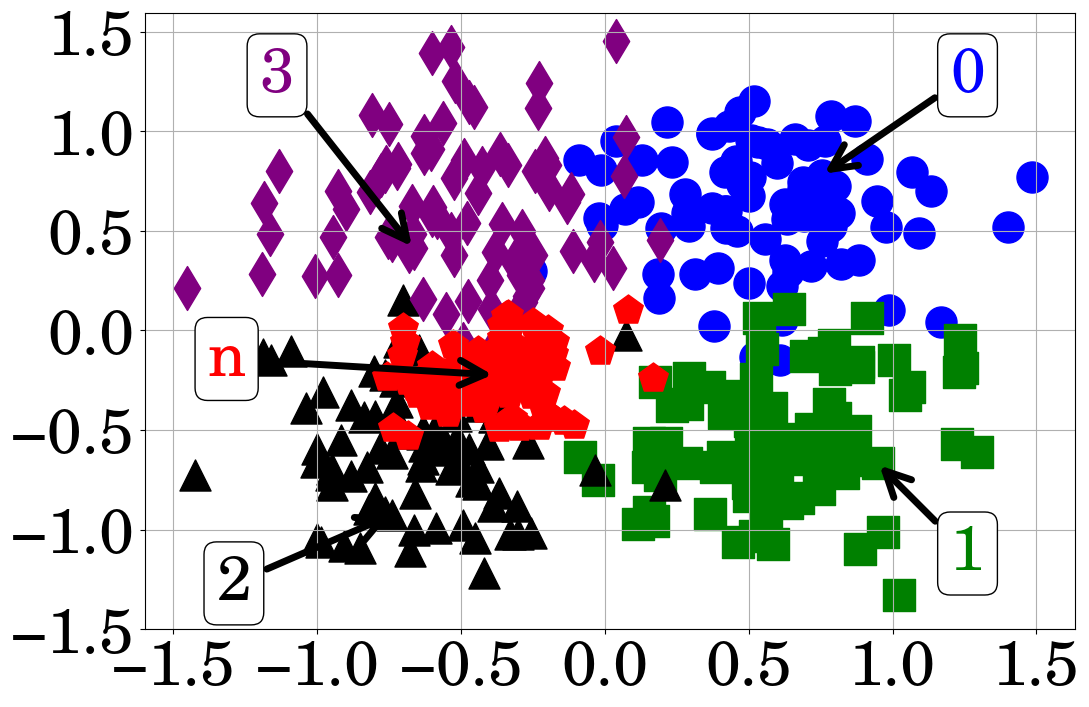

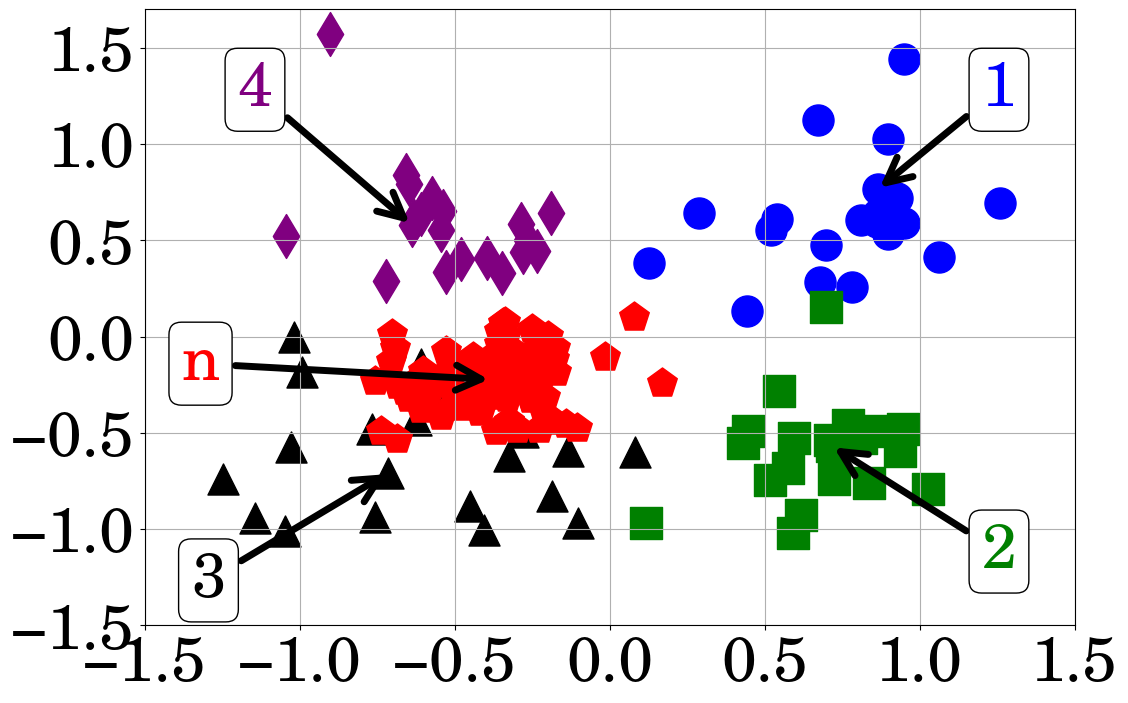

In [15]:

## Plotting Training Data with Noise:
for i in range(4):
    plt.scatter(training_data[i*no_train_data:(i+1)*no_train_data, 0],
                training_data[i*no_train_data:(i+1)*no_train_data, 1],
                marker = markers[i],
                color = colors[i],
                s = s
                )
    
plt.annotate('0',
            xy=training_data[0],
            xytext=mu1+np.array([0.60, 0.60]),
            color = colors[0],
            fontsize = ann_fontsize,
            fontweight = ann_fontweight,
            bbox=ann_bbox,
            arrowprops=dict(facecolor='black', arrowstyle='->', linewidth=5) 
            )
plt.annotate('1',
            xy=training_data[80],
            xytext=mu2+np.array([0.60, -0.60]),
            color = colors[1],
            fontsize = ann_fontsize,
            fontweight = ann_fontweight,
            bbox=ann_bbox,
            arrowprops=dict(facecolor='black', arrowstyle='->', linewidth=5) 
            )
plt.annotate('2',
            xy=training_data[160],
            xytext=mu3+np.array([-0.75, -0.75]),
            color = colors[2],
            fontsize = ann_fontsize,
            fontweight = ann_fontweight,
            bbox=ann_bbox,
            arrowprops=dict(facecolor='black', arrowstyle='->', linewidth=5) 
            )
plt.annotate('3',
            xy=training_data[240],
            xytext=mu4+np.array([-0.60, 0.60]),
            color = colors[3],
            fontsize = ann_fontsize,
            fontweight = ann_fontweight,
            bbox=ann_bbox,
            arrowprops=dict(facecolor='black', arrowstyle='->', linewidth=5) 
            )
    # plt.annotate(str(i),
    #              eval(f'mu{i+1}'),
    #              color = ann_color,
    #              fontsize = ann_fontsize,
    #              fontweight = ann_fontweight,
    #              bbox=ann_bbox            
    #              )
    
plt.scatter(unmunge_data[:, 0],
            unmunge_data[:, 1],
            marker = markers[i+1],
            color = colors[i+1],
            s = s
            )
plt.annotate(f'n',
             xy = torch.mean(unmunge_data, dim=0),
             xytext = torch.mean(unmunge_data, dim=0)+torch.tensor([-1, 0]),
             color = colors[i+1],
             fontsize = ann_fontsize,
             fontweight = ann_fontweight,
             bbox=ann_bbox,
             arrowprops=dict(facecolor='black', arrowstyle='->', linewidth=5) 
             )
plt.grid()
# plt.title('Train Data with Unmunge Noises', fontname=fontname, fontweight=xyticks_fontweight, fontsize=title_fontsize)
plt.xticks(xticks, fontname=fontname, fontweight=xyticks_fontweight, fontsize=xyticks_fontsize)
plt.yticks(yticks, fontname=fontname, fontweight=xyticks_fontweight, fontsize=xyticks_fontsize)
plt.savefig('./results/Toy_Example_Results/Train_Data_with_Unmunge_Noises.png', bbox_inches='tight')
plt.show(block=False)


## Plotting Test Data with Noise:
for i in range(4):
    plt.scatter(test_data[i*no_test_data:(i+1)*no_test_data, 0],
                test_data[i*no_test_data:(i+1)*no_test_data, 1],
                marker = markers[i],
                color = colors[i],
                s = s
                )
    
plt.annotate('1',
            xy=test_data[0],
            xytext=mu1+np.array([0.60, 0.60]),
            color = colors[0],
            fontsize = ann_fontsize,
            fontweight = ann_fontweight,
            bbox=ann_bbox,
            arrowprops=dict(facecolor='black', arrowstyle='->', linewidth=5) 
            )
plt.annotate('2',
            xy=test_data[20],
            xytext=mu2+np.array([0.60, -0.60]),
            color = colors[1],
            fontsize = ann_fontsize,
            fontweight = ann_fontweight,
            bbox=ann_bbox,
            arrowprops=dict(facecolor='black', arrowstyle='->', linewidth=5) 
            )
plt.annotate('3',
            xy=test_data[41],
            xytext=mu3+np.array([-0.75, -0.75]),
            color = colors[2],
            fontsize = ann_fontsize,
            fontweight = ann_fontweight,
            bbox=ann_bbox,
            arrowprops=dict(facecolor='black', arrowstyle='->', linewidth=5) 
            )
plt.annotate('4',
            xy=test_data[65],
            xytext=mu4+np.array([-0.60, 0.60]),
            color = colors[3],
            fontsize = ann_fontsize,
            fontweight = ann_fontweight,
            bbox=ann_bbox,
            arrowprops=dict(facecolor='black', arrowstyle='->', linewidth=5) 
            )
    # plt.annotate(str(i),
    #              eval(f'mu{i+1}'),
    #              color = ann_color,
    #              fontsize = ann_fontsize,
    #              fontweight = ann_fontweight,
    #              bbox=ann_bbox 
    #              )
    
plt.scatter(unmunge_data[:, 0],
            unmunge_data[:, 1],
            marker = markers[i+1],
            color = colors[i+1],
            s = s
            )
plt.annotate(f'n',
             xy = torch.mean(unmunge_data, dim=0),
             xytext = torch.mean(unmunge_data, dim=0)+torch.tensor([-1, 0]),
             color = colors[i+1],
             fontsize = ann_fontsize,
             fontweight = ann_fontweight,
             bbox=ann_bbox,
             arrowprops=dict(facecolor='black', arrowstyle='->', linewidth=5) 
             )
# plt.title('Test Data with Unmunge Noises', fontname=fontname, fontweight=xyticks_fontweight, fontsize=title_fontsize)
plt.xticks(xticks, fontname=fontname, fontweight=xyticks_fontweight, fontsize=xyticks_fontsize)
plt.yticks(yticks, fontname=fontname, fontweight=xyticks_fontweight, fontsize=xyticks_fontsize)
plt.grid()
plt.savefig('./results/Toy_Example_Results/Test_Data_with_Unmunge_Noises.png', bbox_inches='tight')
plt.show(block=False)

#### Unlearn Healper:

In [16]:
unlearn_data = torch.concat(list( x for x, y in train_loader.dataset if y == unlearn_cls)).reshape(-1, 2)
unlearn_label = list( y for _, y in train_loader.dataset if y == unlearn_cls)
unlearn_loader = DataLoader(list(zip(unlearn_data, unlearn_label)), batch_size=batch_size, shuffle=True)

repair_data = torch.concat(list( x for x, y in train_loader.dataset if y != unlearn_cls)).reshape(-1, 2)
repair_label = list( y for _, y in train_loader.dataset if y != unlearn_cls)
repair_loader = DataLoader(list(zip(repair_data, repair_label)), batch_size=batch_size, shuffle=True) 

unmunge_train_data = torch.concat((repair_data, unmunge_data)).type(torch.float)
unmunge_train_labels = torch.concat((torch.tensor(repair_label), torch.tensor([unlearn_cls]*len(unmunge_data))))
unmunge_train_loader = DataLoader(list(zip(unmunge_train_data, unmunge_train_labels)), batch_size=batch_size, shuffle=True)

#### Actual Unlearning(Unmunge):

Accuracy after unlearning on Unlearn Data: 0.0
Accuracy after unlearning on Retain Data: 95.0


/tmp/ipykernel_18967/861193882.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels([f'{int((tick/max(tick_labels))*100)}%' for tick in tick_labels])


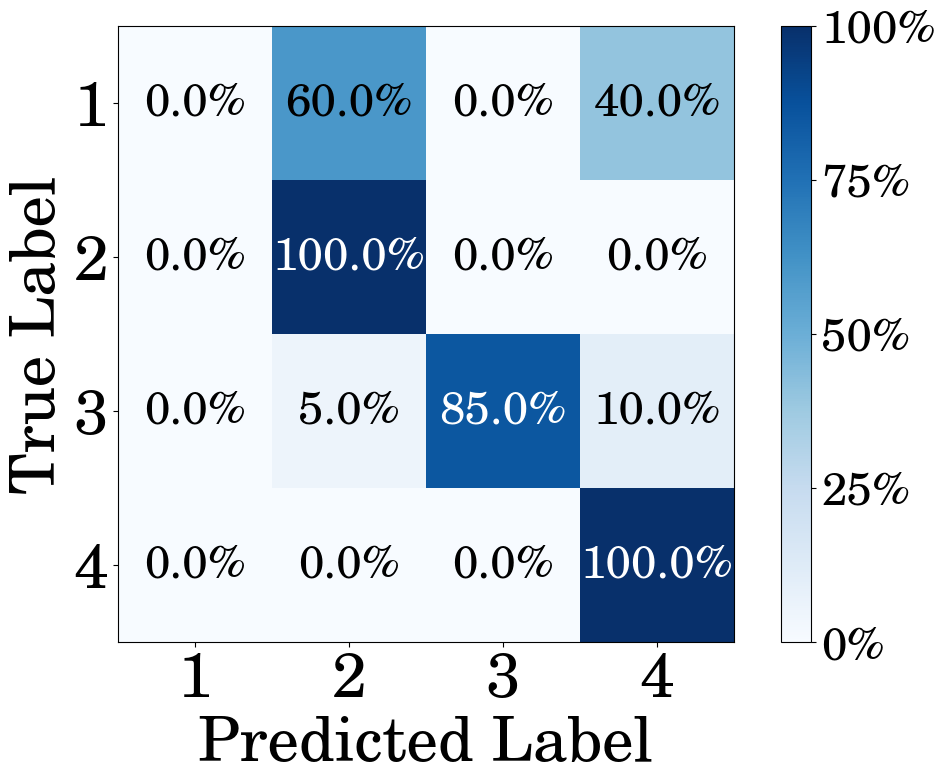

In [17]:
fix_seed(np_seed, torch_seed)
no_of_epochs_unmg = 1
fully_trained_model_umng = copy.deepcopy(model)

## Unlearning
optimizer = optim.Adam(params=fully_trained_model_umng.parameters(), lr = 300*1e-3)
umng_unlearn_model, umng_loss, umng_acc = train(model=fully_trained_model_umng, optimizer=optimizer, train_loader=unmunge_train_loader, no_of_epochs = no_of_epochs_unmg)

confusion_matrix, acc, classwise_accuracy, retain_acc, unlearn_acc = accuracy_(model=umng_unlearn_model, dataloader=test_loader, unlearn_cls = unlearn_cls)
print(f'Accuracy after unlearning on Unlearn Data: {unlearn_acc}')
print(f'Accuracy after unlearning on Retain Data: {retain_acc}')

# Calculate percentages
cm_sum = confusion_matrix.sum(axis=1, keepdims=True)
cm_percentage = confusion_matrix / cm_sum.astype(float) * 100

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = list(range(1,5)))
# cm_display.plot()#colorbar=False)
fig, ax = plt.subplots(figsize = (12, 8))
# fig, ax = plt.subplots(figsize = (14, 10))
cm_display.plot(ax=ax, cmap='Blues', colorbar=False)
plt.xticks(fontname=fontname, fontweight=xyticks_fontweight, fontsize=xyticks_fontsize)  # Set x-tick size and rotate labels
plt.yticks(fontname=fontname, fontweight=xyticks_fontweight, fontsize=xyticks_fontsize)
ax.set_xlabel('Predicted Label',fontname=fontname, fontweight=xyticks_fontweight, fontsize=xyticks_fontsize)
ax.set_ylabel('True Label', fontname=fontname, fontweight=xyticks_fontweight, fontsize=xyticks_fontsize)

# Remove the text annotations
for text in ax.texts:
    text.set_visible(False)

# Annotate each cell with the number and percentage
for i in range(confusion_matrix.shape[0]):
    for j in range(confusion_matrix.shape[1]):
        ax.text(j, i, f'{cm_percentage[i, j]:.1f}%',#%\n({confusion_matrix[i, j]})',
                ha='center', va='center', color='white' if cm_percentage[i, j] >= 70 else 'black')
            
for text in ax.texts:
    text.set_fontsize(xyticks_fontsize-12)  # Set font size
    text.set_fontweight(xyticks_fontweight)  # Set font weight
    text.set_fontname(fontname)
cbar = ax.figure.colorbar(cm_display.im_, ax=ax)

# Format the colorbar ticks to show percentages
tick_labels = cbar.ax.get_yticks()
tick_labels = np.linspace(0, max(tick_labels)-min(tick_labels), 5)
cbar.ax.set_yticklabels([f'{int((tick/max(tick_labels))*100)}%' for tick in tick_labels])

cbar.ax.tick_params(labelsize=xyticks_fontsize-12)
for label in cbar.ax.get_yticklabels():
    label.set_fontweight('normal')
# plt.title(f'Unmunge Confusion Matrix(Epoch - {no_of_epochs_unmg})', fontname=fontname, fontweight=xyticks_fontweight, fontsize=title_fontsize)

plt.savefig('./results/Toy_Example_Results/Unmunge_confusion_matrix_1ep.png', bbox_inches='tight')
plt.show()